# CT reconstruction by Quantum Annealing (REAL)

## Preparation

In [1]:
from itertools import product

import cv2
import numpy as np

import matplotlib as mpl
mpl.use("Agg")

import seaborn as sns
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom

In [2]:
from dwave.cloud import Client
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import LeapHybridSampler
from pyqubo import Array, Num

In [3]:
proj_num_factor = 1
img_size = 30
bits = 10
use_leap = True

In [4]:
client = Client.from_config()
for s in client.get_solvers():
    print(s.id)

hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
hybrid_constrained_quadratic_model_version1
Advantage_system6.4
Advantage2_prototype2.3
Advantage_system4.1


In [5]:
rc = {
    "figure.dpi": 150,
    "figure.autolayout": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}
sns.set_theme(context="notebook", style="white", rc=rc)

## Compute sinogram from Shepp-Logan phantom

In [6]:
# Load Shepp Logan phantom
image = shepp_logan_phantom()
image = image.astype("float32")
image = np.pad(image, ((56, 56), (56, 56)), mode="constant", constant_values=0)
print(f"size: {image.shape[1]}x{image.shape[0]}")
print(f"range: [{image.min():.1f}, {image.max():.1f}]")

size: 512x512
range: [0.0, 1.0]


In [7]:
# Shrink image to fit the number of qubits
image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
image = (image - image.min()) / (image.max() - image.min())
print(f"size: {image.shape[1]}x{image.shape[0]}")
print(f"range: [{image.min():.1f}, {image.max():.1f}]")

size: 30x30
range: [0.0, 1.0]


In [8]:
# Quantize image
factor = 0x1 << bits
image = np.floor(image * factor)
image = np.clip(image, 0, factor - 1)
image = image.astype("float32") / factor

In [9]:
# Make an image grid
H, W = image.shape
xs = np.arange(0, W)
ys = np.arange(0, H)
xs, ys = np.meshgrid(xs, ys)
ones = np.ones_like(xs)
grid = np.stack([xs, ys, ones], axis=-1)
grid = grid.astype("float32")

In [10]:
# Geometry
N = int(max(W, H) * proj_num_factor)
angles = np.linspace(0.0, 2.0 * np.pi, N, endpoint=False)

In [11]:
# Compute sinogram
sino = []
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=9999,
    )

    proj = np.zeros(W)
    for j in range(W):
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            proj[j] += (1 - xt) * (1 - yt) * image[yi, xi]
            proj[j] += xt * (1 - yt) * image[yi, xi + 1]
            proj[j] += (1 - xt) * yt * image[yi + 1, xi]
            proj[j] += xt * yt * image[yi + 1, xi + 1]

    sino.append(proj)

sino = np.stack(sino, axis=0)

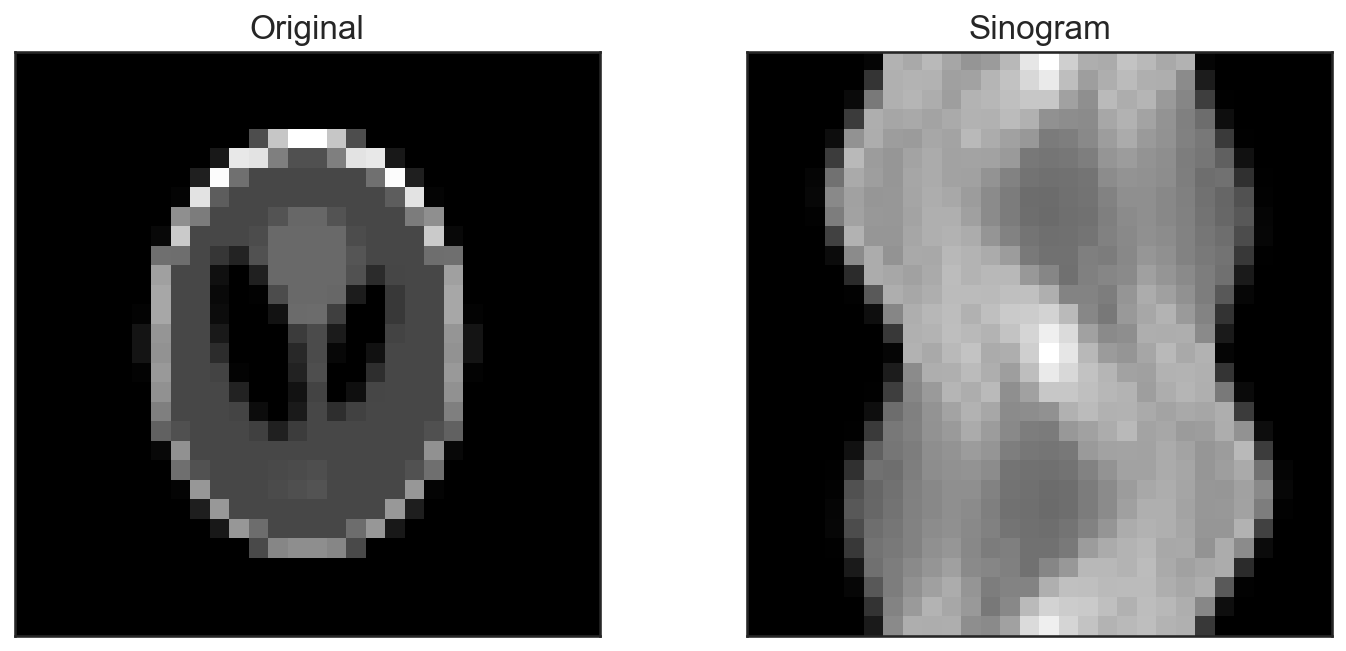

In [12]:
# Show CT image and corresponding sinogram
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
axs[0].imshow(image, vmin=0.0, vmax=1.0, cmap="gray")
axs[0].set_title("Original")
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(sino, cmap="gray")
axs[1].set_title("Sinogram")
axs[1].set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

## CT reconstruction with quantum annealing

In [13]:
# Binary variables
vars = Array.create("x", shape=(H, W, bits), vartype="BINARY")

# Construct QUBO
H0 = Num(0.0)
for n, a in enumerate(angles):
    theta = np.rad2deg(a)
    rot = cv2.getRotationMatrix2D((W // 2, H // 2), theta, 1.0)
    rot_grid = cv2.warpAffine(
        grid,
        rot,
        (W, H),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=9999,
    )

    for j in range(W):
        val = 0.0
        for i in range(H):
            xp, yp = rot_grid[i, j, :2]
            if xp < 0 or xp >= W - 1 or yp < 0 or yp >= H - 1:
                continue

            xi, yi = int(xp), int(yp)
            xt, yt = xp - xi, yp - yi
            for b in range(bits):
                w = (0x1 << b) / factor
                val += w * (1 - xt) * (1 - yt) * vars[yi, xi, b]
                val += w * xt * (1 - yt) * vars[yi, xi + 1, b]
                val += w * (1 - xt) * yt * vars[yi + 1, xi, b]
                val += w * xt * yt * vars[yi + 1, xi + 1, b]

        H0 += (val - sino[n, j]) ** 2

In [14]:
# Compile a model
model = H0.compile()
qubo, _ = model.to_qubo()
label = "Real CT reconstruction"

if use_leap:
    print("Use D-Wave Leap")
    solver = LeapHybridSampler()
else:
    print("Use local computer")
    solver = SimulatedAnnealingSampler()

Use D-Wave Leap


In [15]:
# Perform simulated annealing
sampleset = solver.sample_qubo(qubo, label=label)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
print(best_sample.energy)

1.0070903033483773


In [16]:
# Get reconstruction result
pred = np.zeros((H, W), dtype="float32")
for y, x in product(range(H), range(W)):
    for b in range(bits):
        try:
            v = best_sample.array("x", (y, x, b))
        except IndexError:
            v = 0.0

        pred[y, x] += v * ((0x1 << b) / factor)

# Error
err = np.abs(image - pred)

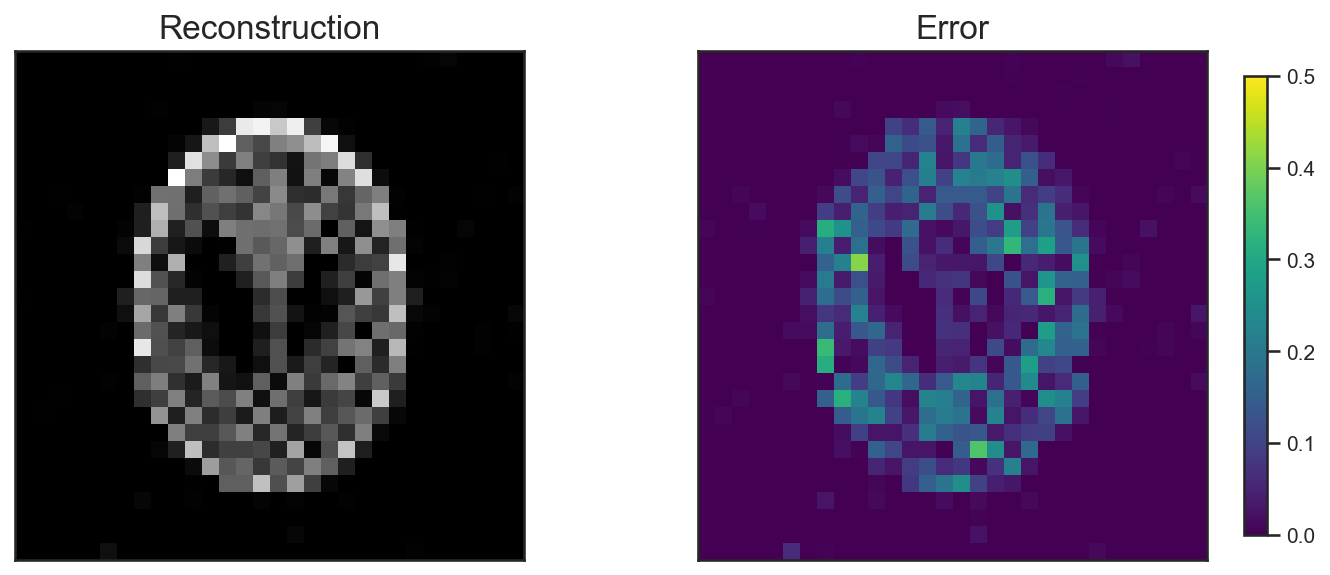

In [17]:
# Show result and error
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(pred, vmin=0.0, vmax=1.0, cmap="gray")
axs[0].set_title("Reconstruction")
axs[0].set(xticks=[], yticks=[])
ims_err = axs[1].imshow(err, vmin=0.0, vmax=0.5, cmap="viridis")
fig.colorbar(ims_err, ax=axs[1], shrink=0.9)
axs[1].set_title("Error")
axs[1].set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

In [18]:
print(f"RMSE: {np.sqrt(np.mean(err**2)):.3f}")

RMSE: 0.078
